참고 : https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [ ]:
import pandas as pd
import numpy as np

# Import Keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.regularizers import L1L2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Sequence Model
- 연속적인 입력(Sequential Input)으로부터 출력을 생성하는 모델
-  입력과 출력이 모두 Sequence Data일수도,하나만 Sequence Data 일 수도 있다.

연속적인 입력으로 부터 6개의 활동 중 하나의 출력값을 생성

=> 시계열 데이터는 순차열 데이터라고 볼 수 있기 때문에 cnn계열의 모델보다 rnn계열 모델에서 더욱 높은 정확성과 효율성을 기대할 수 있음

출처 : https://aidalab.tistory.com/41

### 시계열 분석 - RNN 계열 모델
- RNN : 시간적으로 연속성이 있는 데이터를 처리하려고 고안된 인공 신경망, 이전 은닉층이 현재 은닉층의 입력이 되면서 반복되는 순환 구조를 갖음, 기존 네트워크와 다른 점은 '기억을 갖는다'는 것, RNN의 경우 짧은 시퀀스를 처리할 경우 유리하며, 관련 정보와 그 정보를 사용하는 지점 사이 거리가 멀어지는 경우 학습 능력이 현저하게 저하

- LSTM : 불필요한 연산, 오차 등을 줄여 장기 의존성 문제를 일정 부분 해결


- GRU : RNN의 장기 의존성 문제를 해결하기 위한 알고리즘으로 LSTM의 변형 모델로 구조가 크게 다르지 않지만 매개변수가 적고 소규모 데이터 세트에서는 더 나은 성능을 보여준다.

GRU가 LSTM을 변형한 최신 알고리즘이지만 둘 간의 성능 차이가 명확히 나타나고 있지 않기에 연구 및 프로젝트에 맞게 성능을 직접 테스트 해보고 해당 사이트에 맞는 모델을 사용

출처: https://needjarvis.tistory.com/684 

In [ ]:
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

### 혼동행렬

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix(Y_true, Y_pred):
    
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

    plt.show()

### 데이터 셋

- The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window)

### Inertial signal
- 'train/Inertial Signals/total_acc_x_train.txt': The acceleration signal from the smartphone accelerometer X axis in standard gravity units 'g'. Every row shows a 128 element vector. The same description applies for the 'total_acc_x_train.txt' and 'total_acc_z_train.txt' files for the Y and Z axis. 

- 'train/Inertial Signals/body_acc_x_train.txt': The body acceleration signal obtained by subtracting the gravity from the total acceleration. 

- 'train/Inertial Signals/body_gyro_x_train.txt': The angular velocity vector measured by the gyroscope for each window sample. The units are radians/second. 



In [ ]:
# 데이터 셋 경로 
DATADIR = '/content/drive/MyDrive/UCI HAR Dataset/'

# 사용한 특징 
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
    ]

In [ ]:
# csv 파일 읽어오는 함수 
def _read_csv(filename):

    return pd.read_csv(filename, delim_whitespace=True, header=None)

# function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/MyDrive/UCI HAR Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/MyDrive/UCI HAR Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

### 하이퍼 파라미터 세팅

1) epoch : 30, batch_size : 16, n_hidden : 32, 정확도 : 0.918

2) epoch : 50, batch_size : 16, n_hidden : 32, 정확도 : 0.906

3) epoch : 100, batch_size : 16, n_hidden : 32, 정확도 : 0.914

4) epoch : 100, batch_size : 32, n_hidden : 32, 정확도 : 0.88

5) epoch : 50, batch_size : 32, n_hidden : 32, 정확도 : 0.92

6) epoch : 30, batch_size : 32, n_hidden : 32, 정확도 : 0.89

7) epoch : 30, batch_size : 64, n_hidden : 32, 정확도 : 0.89

8) epoch : 30, batch_size : 64, n_hidden : 32, 정확도 : 0.87

In [ ]:
epochs = 50
batch_size = 64
n_hidden = 32

In [ ]:
#function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

### 데이터 확인

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


### 1-Layer of LSTM

- LSTM (Long Short Term Memory)는 기존의 RNN이 출력과 먼 위치에 있는 정보를 기억할 수 없다는 단점을 보완하여 장/단기 기억을 가능하게 설계한 신경망의 구조/ 주로 시계열 처리에 사용

- input_shape=(timestep, feature) 형태
- 예측하고자하는 target의 갯수가 6 이므로  마지막에 Dense(n_classes = 6 )을 하나 추가

- 활성함수는 Sigmoid : 0.91856

Sigmoid 함수는 모든 실수 입력 값을 0보다 크고 1보다 작은 미분 가능한 수로 변환 

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid')) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                5376      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### 트레이닝

In [ ]:
# Training the model
model.fit(X_train, Y_train, batch_size=batch_size, validation_data=(X_test, Y_test),epochs=epochs)

### 혼동행렬 확인

In [ ]:
# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,0,0,0,27
SITTING,0,417,72,2,0,0
STANDING,0,131,392,7,0,2
WALKING,0,0,0,492,3,1
WALKING_DOWNSTAIRS,0,0,0,12,404,4
WALKING_UPSTAIRS,0,0,0,87,4,380


### 정확도 확인

In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)

93/93 [==============================] - 1s 10ms/step - loss: 0.5622 - accuracy: 0.8806

   cat_crossentropy  ||   accuracy 
  ____________________________________
[0.5621749758720398, 0.8805565237998962]


### 2-Layer of LSTM


### 하이퍼 파라미터 세팅

1) epoch : 30, batch_size : 16, n_hidden : 32, 정확도 : 0.915

2) epoch : 50, batch_size : 16, n_hidden : 32, 정확도 : 0.9203

In [ ]:
n_epochs = 100
n_batch = 16
n_classes = _count_classes(Y_train)

# Bias regularizer value
reg = L1L2(0.01, 0.01)

In [ ]:
# Model execution
model = Sequential()
model.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(32))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

Model Summary: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128, 48)           11136     
                                                                 
 batch_normalization (BatchN  (None, 128, 48)          192       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 128, 48)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                10368     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 198       
                                      

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

Epoch 1/100
460/460 [==============================] - 31s 60ms/step - loss: 1.5704 - accuracy: 0.6688 - val_loss: 1.0497 - val_accuracy: 0.8263
Epoch 2/100
460/460 [==============================] - 26s 57ms/step - loss: 0.7391 - accuracy: 0.8689 - val_loss: 0.6469 - val_accuracy: 0.8480
Epoch 3/100
460/460 [==============================] - 26s 57ms/step - loss: 0.4327 - accuracy: 0.9052 - val_loss: 0.4133 - val_accuracy: 0.8778
Epoch 4/100
460/460 [==============================] - 26s 57ms/step - loss: 0.2587 - accuracy: 0.9272 - val_loss: 0.3001 - val_accuracy: 0.9074
Epoch 5/100
460/460 [==============================] - 26s 57ms/step - loss: 0.2201 - accuracy: 0.9267 - val_loss: 0.4324 - val_accuracy: 0.8504
Epoch 6/100
460/460 [==============================] - 26s 58ms/step - loss: 0.2003 - accuracy: 0.9301 - val_loss: 0.2346 - val_accuracy: 0.9165
Epoch 7/100
460/460 [==============================] - 26s 57ms/step - loss: 0.1898 - accuracy: 0.9353 - val_loss: 0.4208 - val_ac

KeyboardInterrupt: ignored

In [ ]:

# Confusion Matrix
confusion_matrix(Y_test, model.predict(X_test))

In [ ]:
score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)


2.2 Second Model for 2-Layer of LSTM with more hyperparameter tunning

In [ ]:
# Model execution
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, input_dim), return_sequences=True, bias_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(LSTM(48))
model.add(Dropout(0.50))
model.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
model.fit(X_train, Y_train, batch_size=n_batch, validation_data=(X_test, Y_test), epochs=n_epochs)

In [ ]:
# Confusion Matrix
new_confusion_matrix(Y_test, model.predict(X_test))

In [ ]:

score = model.evaluate(X_test, Y_test)

print("\n   cat_crossentropy  ||   accuracy ")
print("  ____________________________________")
print(score)



## Federated Learning 연습_실전X


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle

In [ ]:
# Variables-
epochs = 25
batch_size = 16 #64
num_classes = 6
fig_size = (9,7)

In [ ]:
# FUNCTIONS-
def PREPROCESS(X , y):
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    y = np.array(y)
    return X,y


# def CREATE_MODEL(input_shape):
#     model = Sequential()
#     model.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.50))
#     model.add(LSTM(32))
#     model.add(Dropout(0.50))
#     model.add(Dense(32,activation='relu'))

#     model.add(Dense(num_classes, activation='sigmoid'))
#     return model


 #LSTM
# # Model execution
# model = Sequential()
# model.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
# model.add(BatchNormalization())
# model.add(Dropout(0.50))
# model.add(LSTM(32))
# model.add(Dropout(0.50))
# model.add(Dense(n_classes, activation='sigmoid'))
# print("Model Summary: ")
# model.summary()

# def COMPILE(model):
#     model.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
#     )
#     return model;
    
def FIT(model,X,y,i):
    history = model.fit(
    X,
    y,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(f'./model_{i}.h5', save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.1,
            patience=1
        )
    ],
    verbose=0
    )
    return history,model

def PLOT(history,i):
    epochs_range = range(epochs)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_loss,label="Training Loss")
    plt.plot(epochs_range,val_loss,label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Model {i} - Loss Over Time")
    plt.show()
    
    plt.figure(figsize=fig_size)
    plt.plot(epochs_range,train_acc,label="Training accuracy")
    plt.plot(epochs_range,val_acc,label="Validation accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title(f"Model {i} - Accuracy")
    plt.show()

    
def LOAD_MODELS():
    for i in range(1,4):
        model = load_model(f'./model_{i}.h5')
        all_models.append(model)

def APPLY_WEIGHT_FUNCTION(weights):
    avg_model_weights = []
    n_models = len(all_models) #4
    n_layers = len(all_models[0].get_weights())
    for layer in range(n_layers):
        layer_weights = np.array([model.get_weights()[layer] for model in all_models])
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        avg_model_weights.append(avg_layer_weights)
    return avg_model_weights;

## Model replica number-1


In [ ]:
# MODEL REPLICA NO.1
X_train_1 = X_train[0:1000] #X_train : 7352 (1838)
Y_train_1 = Y_train[0:1000] #Y_train : 7352

In [ ]:
# X_train_1, y_train_1 = PREPROCESS(X_train_1,y_train_1);

In [ ]:
reg = L1L2(0.01, 0.01)

In [ ]:
model_1 = Sequential()
model_1.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model_1.add(BatchNormalization())
model_1.add(Dropout(0.50))
model_1.add(LSTM(32))
model_1.add(Dropout(0.50))
model_1.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model_1.summary()

Model Summary: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 48)           11136     
                                                                 
 batch_normalization (BatchN  (None, 128, 48)          192       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 48)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                10368     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 6)                 198       
                                        

In [ ]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
history1= model_1.fit(X_train_1, Y_train_1, batch_size=16, validation_data=(X_test, Y_test), epochs=50,
callbacks=[
      tf.keras.callbacks.ModelCheckpoint(f'./model_{1}.h5', save_best_only=True),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.1,
          patience=1
      )
  ])

Epoch 1/50
63/63 [==============================] - 17s 152ms/step - loss: 2.2901 - accuracy: 0.4680 - val_loss: 2.4802 - val_accuracy: 0.3831 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 7s 109ms/step - loss: 1.8194 - accuracy: 0.6290 - val_loss: 2.1180 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 7s 110ms/step - loss: 1.5853 - accuracy: 0.6950 - val_loss: 1.8047 - val_accuracy: 0.5701 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 7s 108ms/step - loss: 1.3673 - accuracy: 0.7640 - val_loss: 2.1828 - val_accuracy: 0.4113 - lr: 0.0010
Epoch 5/50
63/63 [==============================] - 8s 135ms/step - loss: 1.3092 - accuracy: 0.7580 - val_loss: 1.8051 - val_accuracy: 0.5657 - lr: 1.0000e-04
Epoch 6/50
63/63 [==============================] - 7s 109ms/step - loss: 1.2080 - accuracy: 0.8220 - val_loss: 1.7433 - val_accuracy: 0.5996 - lr: 1.0000e-05
Epoch 7/50
63/63 [==============================] - 7s 109ms/

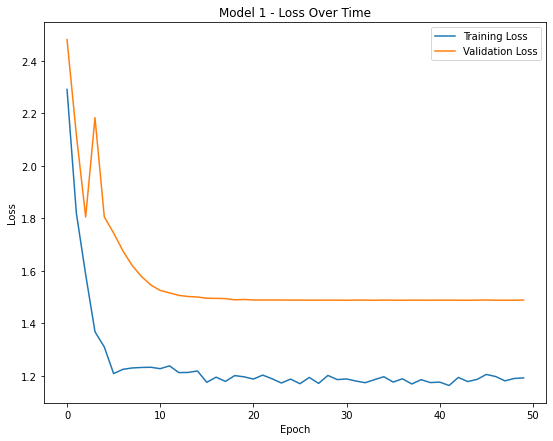

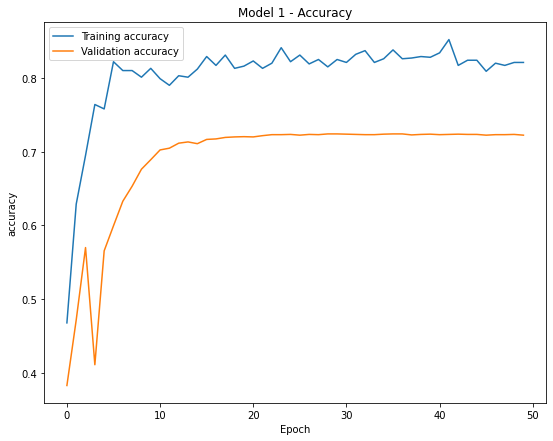

In [ ]:
epochs_range = range(50)

train_loss = history1.history['loss']
val_loss = history1.history['val_loss']
train_acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
    
plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_loss,label="Training Loss")
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Model {1} - Loss Over Time")
plt.show()

plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_acc,label="Training accuracy")
plt.plot(epochs_range,val_acc,label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title(f"Model {1} - Accuracy")
plt.show()

In [ ]:
# MODEL REPLICA NO.2
X_train_2 = X_train[1000:2000]  # [1838:3676] 
Y_train_2 = Y_train[1000:2000]

In [ ]:
model_2 = Sequential()
model_2.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.50))
model_2.add(LSTM(32))
model_2.add(Dropout(0.50))
model_2.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model_2.summary()

Model Summary: 
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128, 48)           11136     
                                                                 
 batch_normalization_2 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128, 48)           0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                10368     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                      

In [ ]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
history2= model_2.fit(X_train_2, Y_train_2, batch_size=16, validation_data=(X_test, Y_test), epochs=50,
                      callbacks=[
      tf.keras.callbacks.ModelCheckpoint(f'./model_{2}.h5', save_best_only=True),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.1,
          patience=1
      )
  ])

Epoch 1/50
63/63 [==============================] - 12s 122ms/step - loss: 2.3140 - accuracy: 0.4590 - val_loss: 2.4810 - val_accuracy: 0.3098 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 7s 105ms/step - loss: 1.7946 - accuracy: 0.6260 - val_loss: 2.3490 - val_accuracy: 0.3003 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 7s 106ms/step - loss: 1.5460 - accuracy: 0.7000 - val_loss: 2.3458 - val_accuracy: 0.4459 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 7s 107ms/step - loss: 1.3344 - accuracy: 0.7680 - val_loss: 1.6966 - val_accuracy: 0.6128 - lr: 0.0010
Epoch 5/50
63/63 [==============================] - 7s 105ms/step - loss: 1.2263 - accuracy: 0.8080 - val_loss: 2.1842 - val_accuracy: 0.5389 - lr: 0.0010
Epoch 6/50
63/63 [==============================] - 7s 106ms/step - loss: 1.1107 - accuracy: 0.8200 - val_loss: 1.7243 - val_accuracy: 0.6284 - lr: 1.0000e-04
Epoch 7/50
63/63 [==============================] - 7s 106ms/step

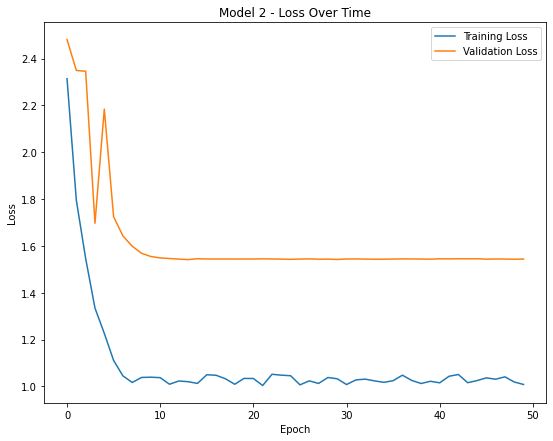

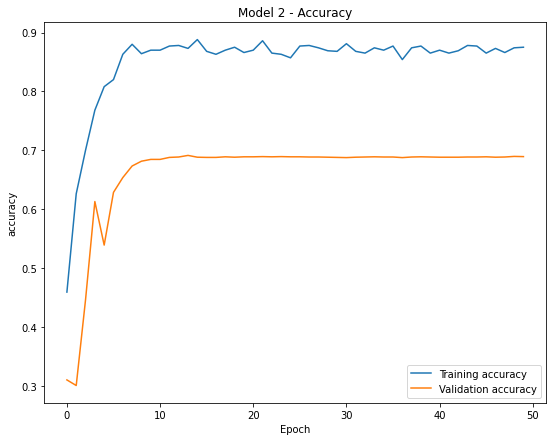

In [ ]:
epochs_range = range(50)

train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
    
plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_loss,label="Training Loss")
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Model {2} - Loss Over Time")
plt.show()

plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_acc,label="Training accuracy")
plt.plot(epochs_range,val_acc,label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title(f"Model {2} - Accuracy")
plt.show()

In [ ]:
# MODEL REPLICA NO.3
X_train_3 = X_train[2000:3000] # [3676:5514]
Y_train_3 = Y_train[2000:3000]

In [ ]:
model_3 = Sequential()
model_3.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.50))
model_3.add(LSTM(32))
model_3.add(Dropout(0.50))
model_3.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model_3.summary()

Model Summary: 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128, 48)           11136     
                                                                 
 batch_normalization_3 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 128, 48)           0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                10368     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                      

In [ ]:
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
history3= model_3.fit(X_train_3, Y_train_3, batch_size=16, validation_data=(X_test, Y_test), epochs=50,
                      callbacks=[
      tf.keras.callbacks.ModelCheckpoint(f'./model_{3}.h5', save_best_only=True),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.1,
          patience=1
      )
  ])

Epoch 1/50
63/63 [==============================] - 11s 122ms/step - loss: 2.3355 - accuracy: 0.4320 - val_loss: 2.3948 - val_accuracy: 0.4048 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 7s 106ms/step - loss: 1.8078 - accuracy: 0.6460 - val_loss: 2.2169 - val_accuracy: 0.4181 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 7s 105ms/step - loss: 1.5559 - accuracy: 0.7040 - val_loss: 2.2139 - val_accuracy: 0.4435 - lr: 0.0010
Epoch 4/50
63/63 [==============================] - 7s 105ms/step - loss: 1.4079 - accuracy: 0.7540 - val_loss: 2.2574 - val_accuracy: 0.4927 - lr: 0.0010
Epoch 5/50
63/63 [==============================] - 7s 105ms/step - loss: 1.2460 - accuracy: 0.8210 - val_loss: 2.0299 - val_accuracy: 0.4971 - lr: 1.0000e-04
Epoch 6/50
63/63 [==============================] - 7s 105ms/step - loss: 1.2264 - accuracy: 0.8090 - val_loss: 2.0698 - val_accuracy: 0.5124 - lr: 1.0000e-04
Epoch 7/50
63/63 [==============================] - 7s 106ms/

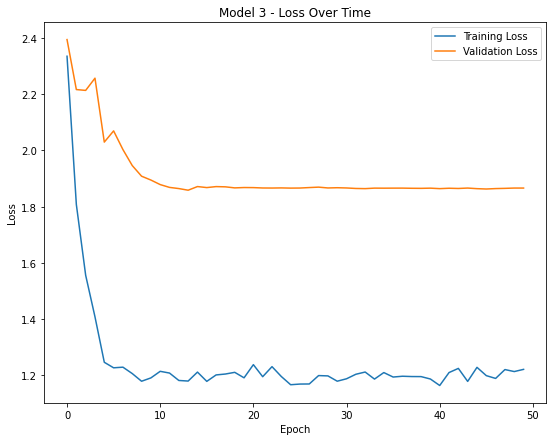

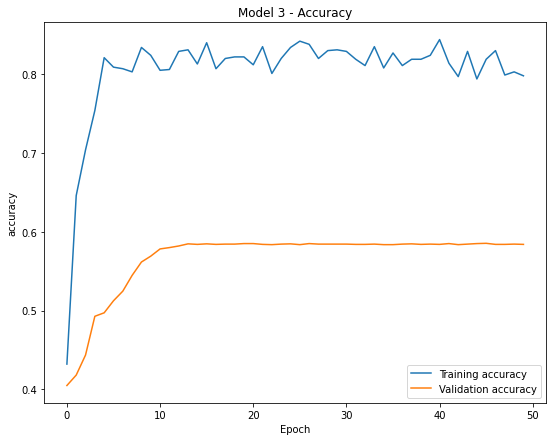

In [ ]:
epochs_range = range(50)

train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
    
plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_loss,label="Training Loss")
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Model {3} - Loss Over Time")
plt.show()

plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_acc,label="Training accuracy")
plt.plot(epochs_range,val_acc,label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title(f"Model {3} - Accuracy")
plt.show()

In [ ]:
# MODEL REPLICA NO.4
X_train_4 = X_train[3000:4000] # 5514:
Y_train_4 = Y_train[3000:4000]

In [ ]:
model_4 = Sequential()
model_4.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model_4.add(BatchNormalization())
model_4.add(Dropout(0.50))
model_4.add(LSTM(32))
model_4.add(Dropout(0.50))
model_4.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model_4.summary()

Model Summary: 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128, 48)           11136     
                                                                 
 batch_normalization_4 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 128, 48)           0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                10368     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 6)                 198       
                                      

In [ ]:
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Training the model
history4= model_4.fit(X_train_4, Y_train_4, batch_size=16, validation_data=(X_test, Y_test), epochs=50,
                      callbacks=[
      tf.keras.callbacks.ModelCheckpoint(f'./model_{4}.h5', save_best_only=True),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.1,
          patience=1
      )
  ])

Epoch 1/50
63/63 [==============================] - 11s 120ms/step - loss: 2.3044 - accuracy: 0.4840 - val_loss: 2.5231 - val_accuracy: 0.3553 - lr: 0.0010
Epoch 2/50
63/63 [==============================] - 7s 105ms/step - loss: 1.8211 - accuracy: 0.6140 - val_loss: 2.5528 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 3/50
63/63 [==============================] - 7s 105ms/step - loss: 1.6327 - accuracy: 0.6690 - val_loss: 2.3751 - val_accuracy: 0.4479 - lr: 1.0000e-04
Epoch 4/50
63/63 [==============================] - 7s 105ms/step - loss: 1.6239 - accuracy: 0.6540 - val_loss: 2.2490 - val_accuracy: 0.4849 - lr: 1.0000e-04
Epoch 5/50
63/63 [==============================] - 7s 105ms/step - loss: 1.5644 - accuracy: 0.7030 - val_loss: 2.1178 - val_accuracy: 0.5188 - lr: 1.0000e-04
Epoch 6/50
63/63 [==============================] - 7s 106ms/step - loss: 1.5564 - accuracy: 0.6890 - val_loss: 2.0184 - val_accuracy: 0.5324 - lr: 1.0000e-04
Epoch 7/50
63/63 [==============================] - 7

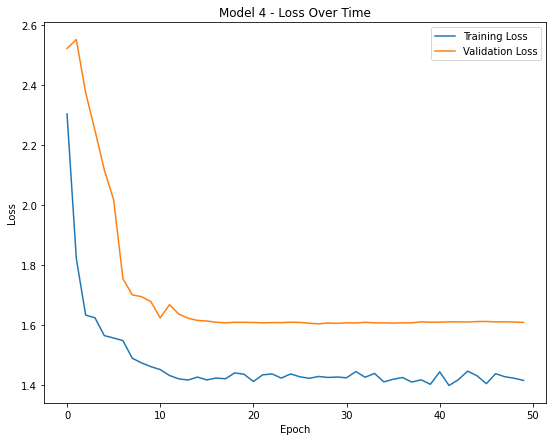

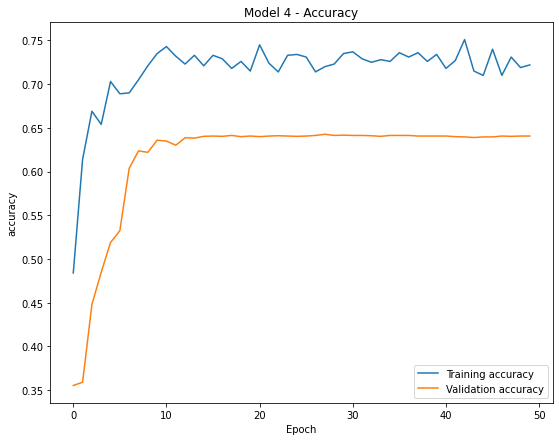

In [ ]:
epochs_range = range(50)

train_loss = history4.history['loss']
val_loss = history4.history['val_loss']
train_acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
    
plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_loss,label="Training Loss")
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Model {4} - Loss Over Time")
plt.show()

plt.figure(figsize=fig_size)
plt.plot(epochs_range,train_acc,label="Training accuracy")
plt.plot(epochs_range,val_acc,label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend()
plt.title(f"Model {4} - Accuracy")
plt.show()

# The Global model

In [ ]:
model_g = Sequential()
model_g.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model_g.add(BatchNormalization())
model_g.add(Dropout(0.50))
model_g.add(LSTM(32))
model_g.add(Dropout(0.50))
model_g.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model_g.summary()

Model Summary: 
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128, 48)           11136     
                                                                 
 batch_normalization_5 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 128, 48)           0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                10368     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                      

In [ ]:

def LOAD_MODELS():
    for i in range(1,5):
        model = load_model(f'./model_{i}.h5')
        all_models.append(model)


In [ ]:
all_models = []
LOAD_MODELS()

In [ ]:

weights = [max(history1.history['accuracy']), max(history2.history['accuracy']),max(history3.history['accuracy']),max(history4.history['accuracy'])]
x = max(weights) # 제일 큰 웨이트값 
idx = weights.index(x) # 제일 큰 웨이트값의 모델의 index
weights[idx] = 1
x = min(weights)
idx = weights.index(x)
weights[idx] = 0.02
for i in range(4):
    if(weights[i] != 1 and weights[i] != 0.02):
        weights[i] = 0.03
        break
avg_model_weights = APPLY_WEIGHT_FUNCTION(weights)

In [ ]:
X_train_g = X_train[4000:]
Y_train_g = Y_train[4000:]

In [ ]:
model_g.set_weights(avg_model_weights)
model_g.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_g= model_g.fit(X_train_g, Y_train_g, batch_size=16, validation_data=(X_test, Y_test), epochs=50,
                      callbacks=[
      tf.keras.callbacks.ModelCheckpoint(f'./model_g.h5', save_best_only=True),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.1,
          patience=1
      )
  ])


Epoch 1/50
210/210 [==============================] - 19s 74ms/step - loss: 1.3663 - accuracy: 0.6894 - val_loss: 1.2169 - val_accuracy: 0.7136 - lr: 0.0010
Epoch 2/50
210/210 [==============================] - 14s 67ms/step - loss: 0.8565 - accuracy: 0.8320 - val_loss: 0.8347 - val_accuracy: 0.8059 - lr: 0.0010
Epoch 3/50
210/210 [==============================] - 14s 67ms/step - loss: 0.5462 - accuracy: 0.9060 - val_loss: 0.5752 - val_accuracy: 0.8453 - lr: 0.0010
Epoch 4/50
210/210 [==============================] - 14s 67ms/step - loss: 0.3375 - accuracy: 0.9397 - val_loss: 0.5889 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 5/50
210/210 [==============================] - 14s 67ms/step - loss: 0.2613 - accuracy: 0.9469 - val_loss: 0.4751 - val_accuracy: 0.8731 - lr: 1.0000e-04
Epoch 6/50
210/210 [==============================] - 14s 67ms/step - loss: 0.2545 - accuracy: 0.9397 - val_loss: 0.4556 - val_accuracy: 0.8734 - lr: 1.0000e-04
Epoch 7/50
210/210 [==============================

In [ ]:
# model_g.set_weights(avg_model_weights)
# model_g.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


_ , accuracy = model_g.evaluate(X_test,Y_test,verbose=0)
print(f"Global Model Accuracy: {round(accuracy*100,2)}%")

Global Model Accuracy: 87.65%


In [ ]:
Y_pred = model_g.predict(X_test)
Y_pred = np.argmax(Y_pred,axis=1)

In [ ]:
# Confusion Matrix
confusion_matrix(Y_test, model_g.predict(X_test))

In [ ]:
model_z = Sequential()
model_z.add(LSTM(48, input_shape=(timesteps, input_dim), return_sequences=True,bias_regularizer=reg ))
model_z.add(BatchNormalization())
model_z.add(Dropout(0.50))
model_z.add(LSTM(32))
model_z.add(Dropout(0.50))
model_z.add(Dense(n_classes, activation='sigmoid'))
print("Model Summary: ")
model_z.summary()

Model Summary: 
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 128, 48)           11136     
                                                                 
 batch_normalization_6 (Batc  (None, 128, 48)          192       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 128, 48)           0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                10368     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                      

In [ ]:
model_z.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
X_train_z = X_train[4000:]
Y_train_z = Y_train[4000:]

In [ ]:
# Training the model
historyz= model_z.fit(X_train_z, Y_train_z, batch_size=16, validation_data=(X_test, Y_test), epochs=50,
                      callbacks=[
      tf.keras.callbacks.ModelCheckpoint(f'./model_z.h5', save_best_only=True),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.1,
          patience=1
      )
  ])

Epoch 1/50
210/210 [==============================] - 18s 71ms/step - loss: 1.8208 - accuracy: 0.5970 - val_loss: 1.8793 - val_accuracy: 0.5555 - lr: 0.0010
Epoch 2/50
210/210 [==============================] - 14s 66ms/step - loss: 1.2502 - accuracy: 0.7381 - val_loss: 1.4003 - val_accuracy: 0.6739 - lr: 0.0010
Epoch 3/50
210/210 [==============================] - 14s 67ms/step - loss: 0.9240 - accuracy: 0.8118 - val_loss: 1.0316 - val_accuracy: 0.7822 - lr: 0.0010
Epoch 4/50
210/210 [==============================] - 14s 66ms/step - loss: 0.6476 - accuracy: 0.8965 - val_loss: 0.8662 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 5/50
210/210 [==============================] - 14s 67ms/step - loss: 0.4331 - accuracy: 0.9320 - val_loss: 0.5895 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 6/50
210/210 [==============================] - 14s 67ms/step - loss: 0.3323 - accuracy: 0.9278 - val_loss: 0.7142 - val_accuracy: 0.8124 - lr: 0.0010
Epoch 7/50
210/210 [==============================] - 14s 

In [ ]:
# model_g.set_weights(avg_model_weights)
# model_g.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


_ , accuracy = model_z.evaluate(X_test,Y_test,verbose=0)
print(f" Model_z Accuracy: {round(accuracy*100,2)}%")

 Model_z Accuracy: 86.29%
